# Create agents and pairs
Create noised version of the reference matrix and pair up individual agents.

In [1]:
import glob
from diversity_abm.utils import compute_thresholds
from diversity_abm.agents import Agent
import itertools
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from multiprocessing import Pool
from sklearn import decomposition
from pathlib import Path

Set hyperparameters and useful variables

In [2]:
space = 'wiki'
model_path = 'diversity_abm/models'
bins = 15
agents_per_bin = 100
date = '12_02_23'

Get animal names, and distance thresholds

In [3]:
models = [f'{model_path}/{space}_euclidean_distance.tsv']
animals = pd.read_csv(f'{model_path}/animal_list.csv')
animals_idx_dict = dict(zip(animals['Animals'].tolist(),
                        list(range(len(animals)))))
thresholds = compute_thresholds(models, 
                                q=[round(n,2) for n in np.arange(0.05, 1.0, 0.05)], 
                                round_at=5)

Import the vector space and scale it.

In [4]:
vecs = pd.read_csv(f'{model_path}/{space}_vectors.tsv',
                   sep='\t', index_col=0, header=None)
vecs_scaled = MinMaxScaler().fit_transform(vecs).round(5)

Import distance matrix, convert distances to long format, cut into quantiles.

In [5]:
dists = pd.read_csv(models[0], sep='\t', index_col=0)
dists.values[np.tril_indices(dists.values.shape[0], 0)] = np.nan
long_dists = pd.melt(dists.reset_index(), id_vars='index').dropna()
long_dists.columns = ['animal_1', 'animal_2', 'distance']
long_dists['distance_qbins'] = pd.qcut(long_dists.distance, 
                                       bins,
                                       labels=range(bins)).astype(float)
long_dists['distance_bins'] = pd.cut(long_dists.distance, 
                                     bins,
                                     labels=range(bins)).astype(float)

In [6]:
categories = pd.cut(long_dists.distance, bins, retbins=True, labels=range(bins))[1]

In [7]:
long_dists.groupby('distance_bins').count()

,animal_1,animal_2,distance,distance_qbins
distance_bins,,,,
0.0,10,10,10,10
1.0,15,15,15,15
2.0,43,43,43,43
3.0,100,100,100,100
4.0,295,295,295,295
5.0,859,859,859,859
6.0,1814,1814,1814,1814
7.0,3679,3679,3679,3679
8.0,5734,5734,5734,5734


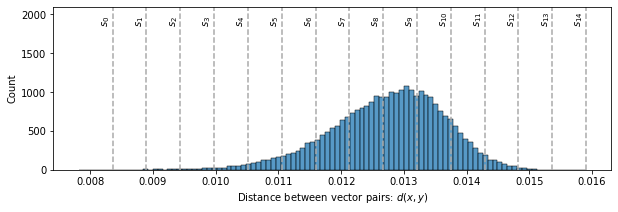

In [8]:
fig, ax = plt.subplots(figsize=(10,3))
for idx, c in enumerate(categories[1:]):
    plt.axvline(c, linestyle='--', color='darkgrey')
    plt.annotate(f'$s_{{{idx}}}$', 
                 xy=(c-0.0002,1900), xycoords='data', 
                 rotation=90, fontsize=10)
sns.histplot(long_dists.distance)
plt.ylim(0,2100)
plt.xlabel('Distance between vector pairs: $d(x,y)$')
plt.show()

Now let's create a number of agents for each "noise level": for each quantile, we swap the position in the vector space of each pair of animals whose distance is below that quantile. <br> To introduce diversity between agents, we change the order in which the swapping is performed.

In [9]:
for p in ['noised_vectors', 'noised_distance_matrices', 'mappings']:
    opath = Path(model_path) / date / p
    opath.mkdir(parents=True, exist_ok=True)

#### Generate agents

In [10]:
noised_dists = []
noised_vecs = []

for b in range(bins):
    print(f'Processing bin {b+1} of {bins}')
    bin_df = long_dists[(long_dists['distance_bins'] <= b)]

    for a_idx in range(agents_per_bin):

        subthr_pairs = list(bin_df.sample(frac=.7)[['animal_1',
                                                   'animal_2']].to_records(index=False))
        
        #print(len(subthr_pairs))
        idx_dict_copy = animals_idx_dict.copy()
        for animal_1, animal_2 in subthr_pairs:
            idx_1 = idx_dict_copy[animal_1]
            idx_2 = idx_dict_copy[animal_2]
            idx_dict_copy[animal_1] = idx_2
            idx_dict_copy[animal_2] = idx_1
        new_idx = dict(sorted(idx_dict_copy.items(), 
                              key=lambda item: item[1])).keys()

        # Make and save vecs
        fname = f'{space}_{b}_{a_idx}.tsv'
        agent_vec_df = pd.DataFrame(vecs_scaled.copy()) 
        agent_vec_df.index = new_idx
        agent_vec_df = agent_vec_df.reindex(animals_idx_dict.keys())
        noised_vecs.append((a_idx, b, agent_vec_df))

        # Make and save distances
        agent_dist = euclidean_distances(agent_vec_df.values, 
                                         agent_vec_df.values) / 400
        agent_dist_df = pd.DataFrame(agent_dist.round(5))
        agent_dist_df.index = agent_vec_df.index
        agent_dist_df.columns = agent_dist_df.index
        noised_dists.append((a_idx, b, agent_dist_df))

Processing bin 1 of 15
Processing bin 2 of 15
Processing bin 3 of 15
Processing bin 4 of 15
Processing bin 5 of 15
Processing bin 6 of 15
Processing bin 7 of 15
Processing bin 8 of 15
Processing bin 9 of 15
Processing bin 10 of 15
Processing bin 11 of 15
Processing bin 12 of 15
Processing bin 13 of 15
Processing bin 14 of 15
Processing bin 15 of 15


## Create pairs

Define function to compute distances

In [11]:
def _compute_distance(pair):
    ''' Computes distance between pair of agents '''
    distance = np.mean(np.sqrt(np.sum(np.square(pair[0][2] - pair[1][2]), axis=1)))
    noise_level1 = pair[0][1]
    noise_level2 = pair[1][1]
    idx1 = pair[0][0]
    idx2 = pair[1][0]
    return (idx1, idx2,
            noise_level1, noise_level2,
            distance)

Compute distances between all pairs of agents

In [12]:
pair_dists = {}
for b in range(bins):
    print(f'Bin {b}')
    ref_vecs = [nv for nv in noised_vecs if nv[1] == 0]
    b_vecs = [nv for nv in noised_vecs if nv[1] == b]
    b_combs = list(itertools.product(b_vecs, ref_vecs))
    pool = Pool(processes=30)
    b_dists = pool.map(_compute_distance, b_combs)
    pair_dists[b] = b_dists
    pool.close()

Bin 0
Bin 1
Bin 2
Bin 3
Bin 4
Bin 5
Bin 6
Bin 7
Bin 8
Bin 9
Bin 10
Bin 11
Bin 12
Bin 13
Bin 14


In [13]:
dmeans = []
for nl, vals in pair_dists.items():
    dmeans.append(np.mean([v[-1] for v in vals]))

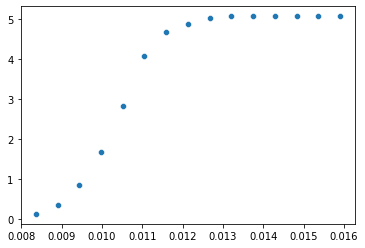

In [14]:
sns.scatterplot(x=categories[1:], y=dmeans)
plt.show()

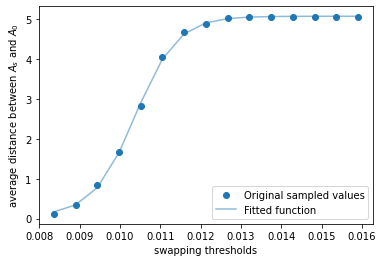

In [15]:
from scipy.optimize import curve_fit
def logifunc(x,A,x0,k,off):
    return A / (1 + np.exp(-k*(x-x0)))+off
popt, pcov = curve_fit(logifunc, categories[1:], dmeans)
plt.scatter(categories[1:], dmeans, label='Original sampled values')
plt.plot(categories[1:], logifunc(categories[1:], *popt), '-',label='Fitted function', alpha=.5)
plt.xlabel('swapping thresholds')
plt.ylabel('average distance between $A_{s}$ and $A_{0}$')
plt.legend()

In [16]:
def rev_logifunc(y,A,x0,k,off):
    return x0 - (np.log(A/(y-off) - 1) / k)

In [17]:
A=popt[0]; x0=popt[1]; k=popt[2]; off=popt[3]
agent_distances = np.linspace(np.min(dmeans)+0.1, np.max(dmeans), num=20)
animal_distances = [rev_logifunc(y,A,x0,k,off) for y in list(agent_distances)]

In [18]:
A.round(3), x0.round(2), k.round(2), off.round(2)

(5.014, 0.01, 1920.46, 0.07)

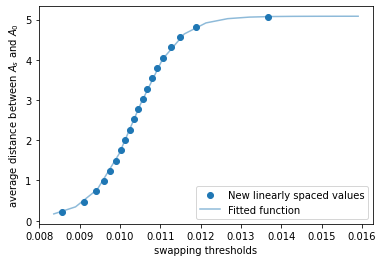

In [19]:

plt.scatter(animal_distances, agent_distances, label='New linearly spaced values')
plt.plot(categories[1:], logifunc(categories[1:], *popt), '-',label='Fitted function', alpha=.5)
plt.xlabel('swapping thresholds')
plt.ylabel('average distance between $A_{s}$ and $A_{0}$')
plt.legend()

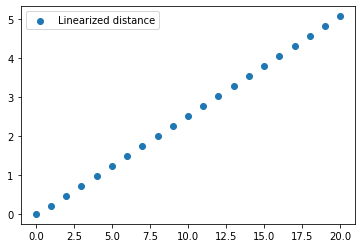

In [20]:
plt.scatter(range(21), [categories[1]] + list(agent_distances), label='Linearized distance')
plt.legend()

### Generate groups for equally spaced thresholds

In [21]:
import json 

noised_dists = []
noised_vecs = []

for b, x in enumerate([categories[1]] + list(animal_distances)): #
    print(f'Processing bin {b+1} of {len(animal_distances)}')
    bin_df = long_dists[(long_dists['distance'] <= x)]

    for a_idx in range(agents_per_bin):
        
        subthr_pairs = list(bin_df.sample(frac=.7)[['animal_1',
                                                    'animal_2']].to_records(index=False))
        
        idx_dict_copy = animals_idx_dict.copy()
        for animal_1, animal_2 in subthr_pairs:
            idx_1 = idx_dict_copy[animal_1]
            idx_2 = idx_dict_copy[animal_2]
            idx_dict_copy[animal_1] = idx_2
            idx_dict_copy[animal_2] = idx_1
        new_idx = dict(sorted(idx_dict_copy.items(), 
                              key=lambda item: item[1])).keys()
        
        # Save dictionary for originality calculations
        fname = f'{space}_{b}_{a_idx}'
        json.dump(idx_dict_copy, 
                  open(f'{model_path}/{date}/mappings/{fname}.json', 'w'))
        
        # Make and save vecs
        agent_vec_df = pd.DataFrame(vecs_scaled.copy()) 
        agent_vec_df.index = new_idx
        agent_vec_df = agent_vec_df.reindex(animals_idx_dict.keys()) # sorting
        agent_vec_df.to_csv(f'{model_path}/{date}/noised_vectors/{fname}.tsv',
                            sep='\t')
        noised_vecs.append((a_idx, b, agent_vec_df))

        # Make and save distances
        agent_dist = euclidean_distances(agent_vec_df.values, 
                                         agent_vec_df.values) / 400
        agent_dist_df = pd.DataFrame(agent_dist.round(5))
        agent_dist_df.index = agent_vec_df.index
        agent_dist_df.columns = agent_dist_df.index
        agent_dist_df.to_csv(f'{model_path}/{date}/noised_distance_matrices/{fname}.tsv',
                             sep='\t')
        noised_dists.append((a_idx, b, agent_dist_df))

Processing bin 1 of 20
Processing bin 2 of 20
Processing bin 3 of 20
Processing bin 4 of 20
Processing bin 5 of 20
Processing bin 6 of 20
Processing bin 7 of 20
Processing bin 8 of 20
Processing bin 9 of 20
Processing bin 10 of 20
Processing bin 11 of 20
Processing bin 12 of 20
Processing bin 13 of 20
Processing bin 14 of 20
Processing bin 15 of 20
Processing bin 16 of 20
Processing bin 17 of 20
Processing bin 18 of 20
Processing bin 19 of 20
Processing bin 20 of 20
Processing bin 21 of 20


### Sample pairs

In [22]:
pair_dists = {}
for b in range(21):
    print(f'Bin {b}')
    ref_vecs = [nv for nv in noised_vecs if nv[1] == 0]
    b_vecs = [nv for nv in noised_vecs if nv[1] == b]
    b_combs = list(itertools.product(b_vecs, ref_vecs))
    pool = Pool(processes=30)
    b_dists = pool.map(_compute_distance, b_combs)
    pair_dists[b] = b_dists
    pool.close()

Bin 0
Bin 1
Bin 2
Bin 3
Bin 4
Bin 5
Bin 6
Bin 7
Bin 8
Bin 9
Bin 10
Bin 11
Bin 12
Bin 13
Bin 14
Bin 15
Bin 16
Bin 17
Bin 18
Bin 19
Bin 20


In [23]:
dist_dfs = []
for idx, k in enumerate(pair_dists.keys()):
    pair_dist_df = pd.DataFrame(pair_dists[k], columns=['idx1', 'idx2', 
                                                        'noise_level1', 'noise_level2',
                                                        'distance'])
    for c in ['idx1', 'idx2', 'noise_level1', 'noise_level2']:
        pair_dist_df[c] = pair_dist_df[c].astype(str)
    print(pair_dist_df.shape[0])
    dist_dfs.append(pair_dist_df)
pairs_dist_df = pd.concat(dist_dfs, ignore_index=True)

pairs_dist_df['fname_1'] = 'wiki_' + pairs_dist_df['noise_level1'] + '_' + pairs_dist_df['idx1'] + '.tsv'
pairs_dist_df['fname_2'] = 'wiki_' + pairs_dist_df['noise_level2'] + '_' + pairs_dist_df['idx2'] + '.tsv'

sampled_lst = []
for idx, b in enumerate(range(21)):
    b_sampled = pairs_dist_df[pairs_dist_df['noise_level1'] == str(b)].sample(n=agents_per_bin)
    sampled_lst.append(b_sampled)
sampled_all = pd.concat(sampled_lst, ignore_index=False)
sampled_all.to_csv(f'{model_path}/{date}/sampled_pairs.tsv', sep='\t')

10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000


In [24]:
mdists = sampled_all.groupby('noise_level1').distance.mean().reset_index()

In [25]:
sampled_all.groupby('noise_level1').distance.aggregate(['mean', 'std'])

,mean,std
noise_level1,,
0,0.121669,0.038453
1,0.184329,0.036603
10,2.444400,0.075750
11,2.701040,0.060386
12,2.944214,0.077392
13,3.215029,0.067886
14,3.534971,0.067904
15,3.790923,0.053336
16,4.097726,0.052497


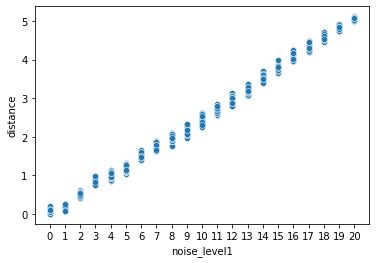

In [26]:
sns.scatterplot(data=sampled_all, x='noise_level1', y='distance')
plt.show()

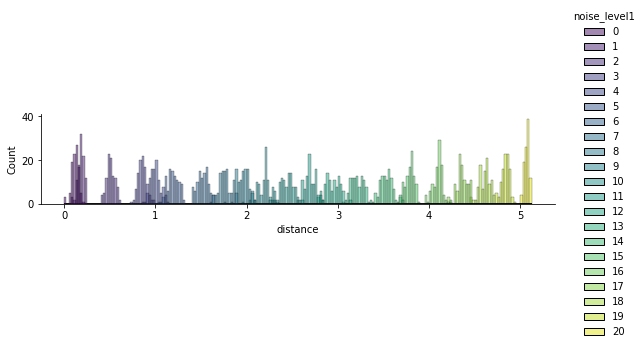

In [27]:
sns.displot(data=sampled_all, 
            hue='noise_level1', x='distance', palette='viridis', binwidth=0.025,
            height=2, aspect=4)
plt.show()

In [28]:
mdists['noise_level1'] = mdists['noise_level1'].astype(int)
with open(f"diversity_abm/models/{date}/dist_mapping.json", "w") as outfile:
    json.dump(dict(zip(range(21), 
                       mdists.sort_values(by='noise_level1').distance.tolist())), 
              outfile)

In [29]:
mdists.sort_values(by='noise_level1')

,noise_level1,distance
0,0,0.121669
1,1,0.184329
12,2,0.509576
14,3,0.858666
15,4,1.000445
16,5,1.192483
17,6,1.519965
18,7,1.765310
19,8,1.965342
20,9,2.192045


### Check distances ... 

In [30]:
import glob 
import pandas as pd
import itertools

fs = glob.glob(f'{model_path}/{date}/noised_distance_matrices/*.tsv')

dfs = []
for f in fs:
    df = pd.read_csv(f, sep='\t', index_col=0)
    dfs.append((int(f.split('/')[-1].split('_')[-1].split('.')[0]), 
                int(f.split('/')[-1].split('_')[1]), 
                df))

In [31]:
def _compute_distance(pair):
    ''' Computes distance between pair of agents '''
    distance = np.abs((pair[0][2] - pair[1][2]).values).ravel().sum() / 2
    noise_level1 = pair[0][1]
    noise_level2 = pair[1][1]
    idx1 = pair[0][0]
    idx2 = pair[1][0]
    return (idx1, idx2,
            noise_level1, noise_level2,
            distance)

In [32]:
pair_dists = {}
for b in range(0,1): # 21
    print(f'Bin {b}')
    ref_vecs = [nv for nv in noised_dists if nv[1] == 0] # dfs
    b_vecs = [nv for nv in noised_dists if nv[1] == b]
    b_combs = list(itertools.product(b_vecs, ref_vecs))
    pool = Pool(processes=20)
    b_dists = pool.map(_compute_distance, b_combs)
    pair_dists[b] = b_dists
    pool.close()

Bin 0


In [33]:
dist_dfs = []
for idx, k in enumerate(pair_dists.keys()):
    pair_dist_df = pd.DataFrame(pair_dists[k], columns=['idx1', 'idx2', 
                                                        'noise_level1', 'noise_level2',
                                                        'distance'])
    for c in ['idx1', 'idx2', 'noise_level1', 'noise_level2']:
        pair_dist_df[c] = pair_dist_df[c].astype(str)
    dist_dfs.append(pair_dist_df)
pairs_dist_df = pd.concat(dist_dfs, ignore_index=True)

In [202]:
pairs_dist_df.distance.nunique()

1986